Found 2823 images, 2823 masks


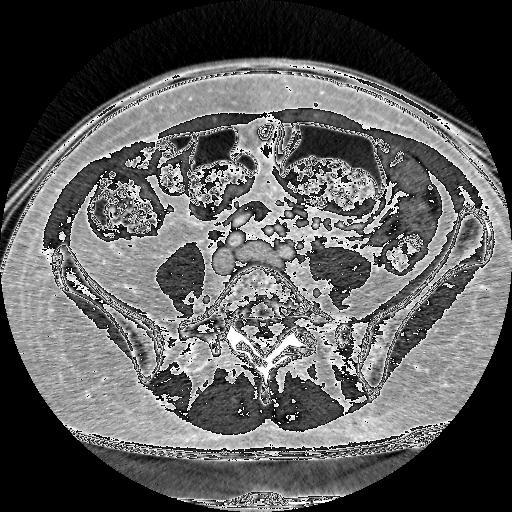

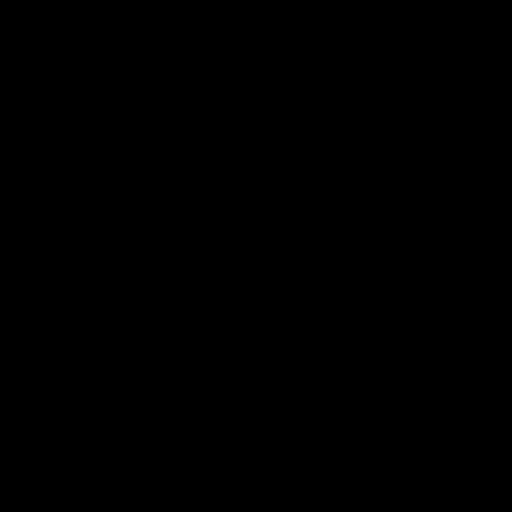

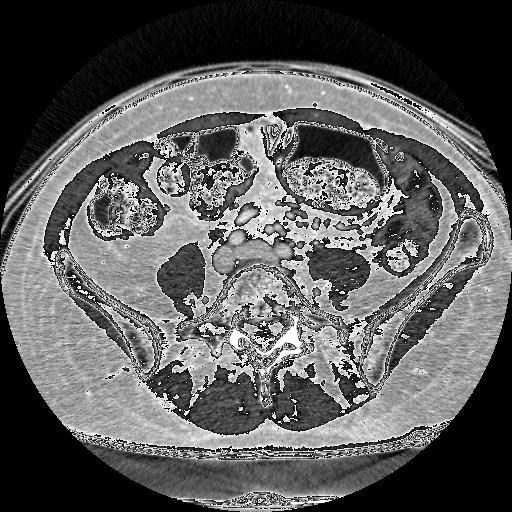

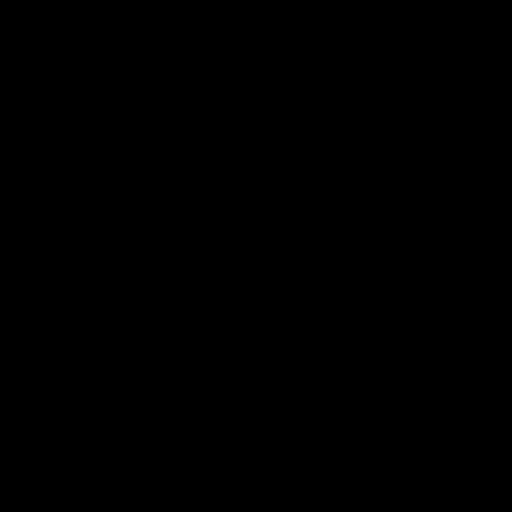

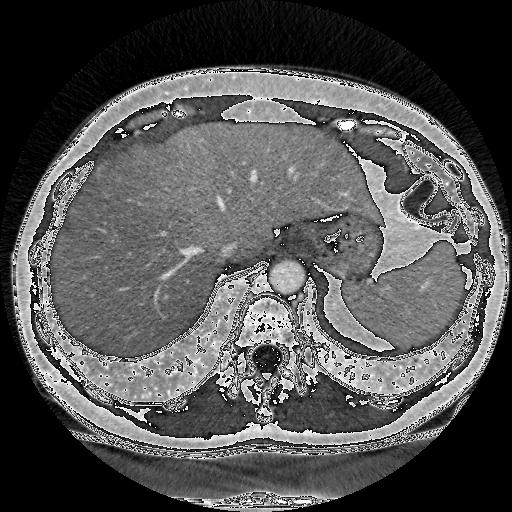

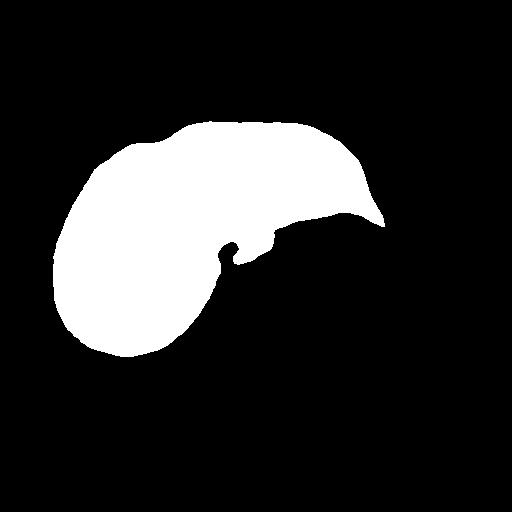

In [1]:
import glob, os
from PIL import Image

# 1) Set your base path to wherever your folder landed in Colab:
BASE_DIR    = "Liver Segmentation Dataset"
IMAGE_DIR   = os.path.join(BASE_DIR, "images")
MASK_DIR    = os.path.join(BASE_DIR, "liver_masks")

# 2) Glob all .jpg files
img_paths  = sorted(glob.glob(os.path.join(IMAGE_DIR,  "*.jpg")))
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR,   "*.jpg")))

# 3) Sanity-check
print(f"Found {len(img_paths)} images, {len(mask_paths)} masks")
assert len(img_paths)>0 and len(mask_paths)>0, "Check your IMAGE_DIR / MASK_DIR!"
assert len(img_paths)==len(mask_paths), "Image/mask count mismatch!"

# 4) (Optional) Peek at a couple
for i in range(3):
    img  = Image.open(img_paths[i])
    msk  = Image.open(mask_paths[i])
    display(img, msk)


Images: 2823 | Liver masks: 2823 | Tumor masks: 2823


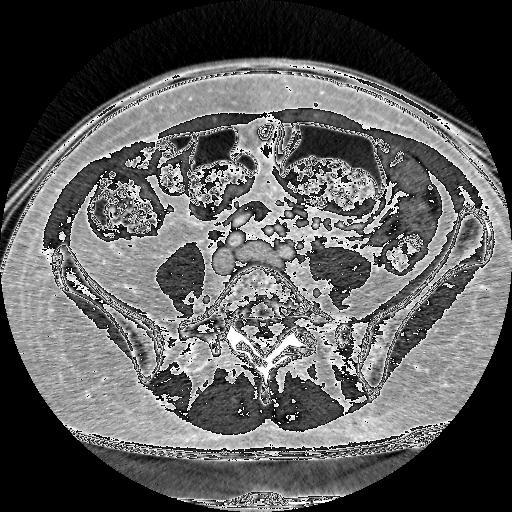

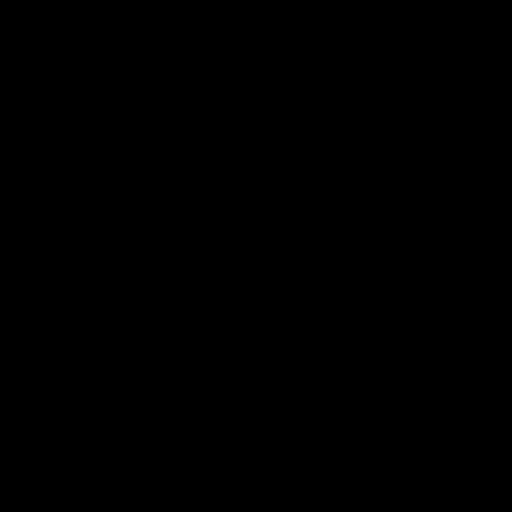

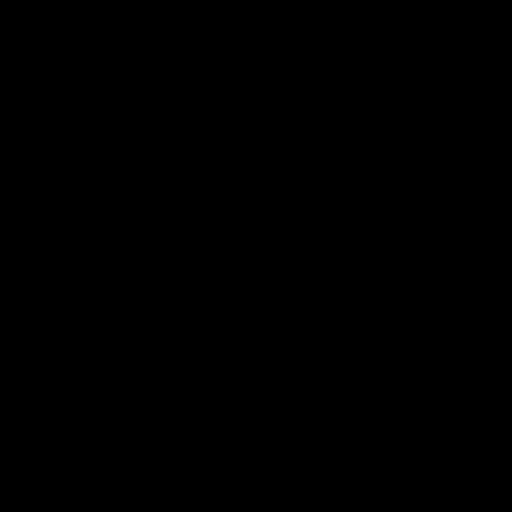

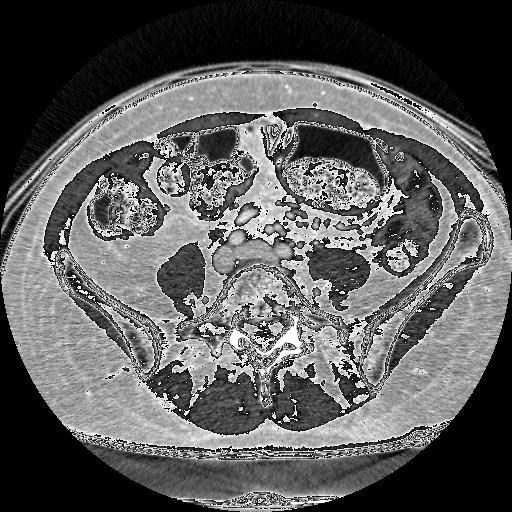

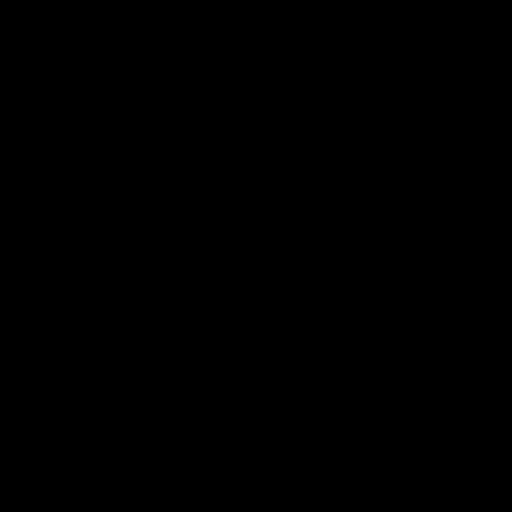

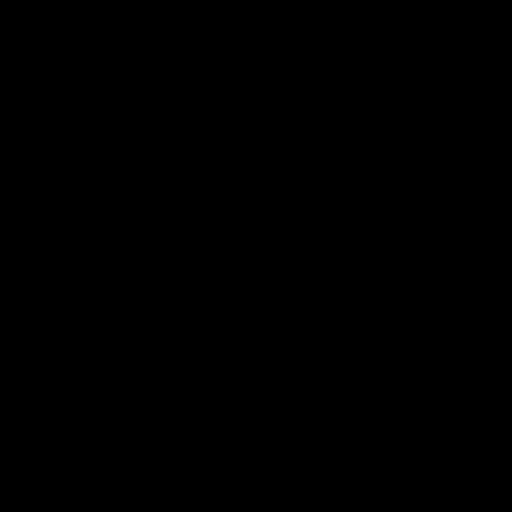

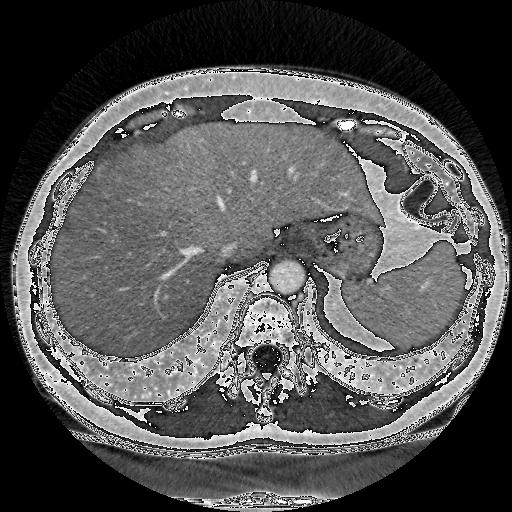

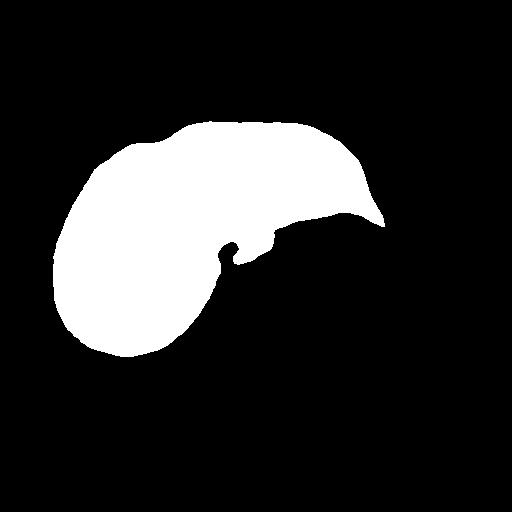

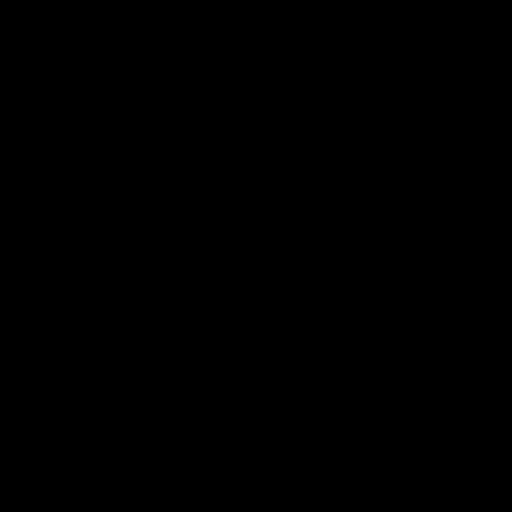

In [3]:
import glob, os
from PIL import Image

BASE_DIR   = "Liver Segmentation Dataset"
IMAGE_DIR  = os.path.join(BASE_DIR, "images")
LIVER_MASK = os.path.join(BASE_DIR, "liver_masks")
TUMOR_MASK = os.path.join(BASE_DIR, "tumor_masks")

# collect images & liver masks (flat structure)
img_paths = sorted(glob.glob(os.path.join(IMAGE_DIR,    "*.jpg")))
liv_paths = sorted(glob.glob(os.path.join(LIVER_MASK,   "*.jpg")))

# collect tumor masks (possibly nested)
# Option A: one level of subfolders
tum_paths = sorted(glob.glob(os.path.join(TUMOR_MASK, "*", "*.jpg")))

# Option B: arbitrary depth
# tum_paths = sorted(glob.glob(os.path.join(TUMOR_MASK, "**", "*.jpg"), recursive=True))

# diagnostic print
print(f"Images: {len(img_paths)} | Liver masks: {len(liv_paths)} | Tumor masks: {len(tum_paths)}")

# checks
assert len(img_paths) > 0, "No input images found!"
assert len(liv_paths) > 0, "No liver masks found!"
assert len(tum_paths) > 0, "No tumor masks found!"
assert len(img_paths)==len(liv_paths), "Image count ≠ liver mask count!"
assert len(img_paths)==len(tum_paths), "Image count ≠ tumor mask count!"

# peek
for i in range(min(3, len(img_paths))):
    img = Image.open(img_paths[i])
    m1  = Image.open(liv_paths[i])
    m2  = Image.open(tum_paths[i])
    display(img, m1, m2)


In [4]:
import os, glob, random
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models

c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
IMG_SIZE = 256
IMG_TF = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
MSK_TF = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),  # [0,1]
])

In [6]:
class LiverTumorSegDataset(Dataset):
    def __init__(self, imgs, lmsks, tmsks, img_tf, msk_tf):
        self.imgs, self.lmsks, self.tmsks = imgs, lmsks, tmsks
        self.itf, self.mtf = img_tf, msk_tf
    def __len__(self): return len(self.imgs)
    def __getitem__(self, i):
        img   = Image.open(self.imgs[i]).convert('RGB')
        lmask = Image.open(self.lmsks[i]).convert('L')
        tmask = Image.open(self.tmsks[i]).convert('L')
        img   = self.itf(img)
        lmsk  = (self.mtf(lmask)>0.5).float()
        tmsk  = (self.mtf(tmask)>0.5).float()
        mask  = torch.cat([lmsk, tmsk], dim=0)
        return img, mask

class LiverTumorClsDataset(Dataset):
    def __init__(self, imgs, tmsks, img_tf):
        self.imgs, self.tmsks = imgs, tmsks
        self.itf = img_tf
    def __len__(self): return len(self.imgs)
    def __getitem__(self, i):
        img   = Image.open(self.imgs[i]).convert('RGB')
        tmask = Image.open(self.tmsks[i]).convert('L')
        img   = self.itf(img)
        label = 1 if np.array(tmask).sum()>0 else 0
        return img, label

In [7]:
SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
# Segmentation
full_seg = LiverTumorSegDataset(img_paths, liv_paths, tum_paths, IMG_TF, MSK_TF)
n_val    = int(0.2*len(full_seg))
seg_trn, seg_val = random_split(full_seg, [len(full_seg)-n_val, n_val])
# Classification
full_cls = LiverTumorClsDataset(img_paths, tum_paths, IMG_TF)
cls_trn, cls_val = random_split(full_cls, [len(full_cls)-n_val, n_val])

# Weighted sampler for classification
# Compute class counts
labels = [full_cls[i][1] for i in range(len(full_cls))]
count_pos = sum(labels)
count_neg = len(labels) - count_pos
w_pos = len(labels)/(2*count_pos)
w_neg = len(labels)/(2*count_neg)
sample_weights = [w_pos if l==1 else w_neg for l in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH = 8
seg_trn_loader = DataLoader(seg_trn, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
seg_val_loader = DataLoader(seg_val, batch_size=BATCH, shuffle=False, num_workers=2)
cls_trn_loader = DataLoader(cls_trn, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
cls_val_loader = DataLoader(cls_val, batch_size=BATCH, shuffle=False, num_workers=2)


In [8]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=2):
        super().__init__()
        def CBR(i,o): return nn.Sequential(nn.Conv2d(i,o,3,padding=1), nn.BatchNorm2d(o), nn.ReLU())
        self.enc1 = nn.Sequential(CBR(in_ch,64), CBR(64,64))
        self.enc2 = nn.Sequential(CBR(64,128),CBR(128,128))
        self.enc3 = nn.Sequential(CBR(128,256),CBR(256,256))
        self.enc4 = nn.Sequential(CBR(256,512),CBR(512,512))
        self.pool = nn.MaxPool2d(2)
        self.center = nn.Sequential(CBR(512,1024),CBR(1024,1024))
        self.up = lambda i,o: nn.ConvTranspose2d(i,o,2,stride=2)
        self.dec4 = nn.Sequential(CBR(1024,512),CBR(512,512))
        self.dec3 = nn.Sequential(CBR(512,256),CBR(256,256))
        self.dec2 = nn.Sequential(CBR(256,128),CBR(128,128))
        self.dec1 = nn.Sequential(CBR(128,64),CBR(64,64))
        self.final= nn.Conv2d(64,out_ch,1)
    def forward(self,x):
        e1=self.enc1(x); e2=self.enc2(self.pool(e1))
        e3=self.enc3(self.pool(e2)); e4=self.enc4(self.pool(e3))
        c = self.center(self.pool(e4))
        d4=self.dec4(torch.cat([self.up(1024,512)(c),e4],1))
        d3=self.dec3(torch.cat([self.up(512,256)(d4),e3],1))
        d2=self.dec2(torch.cat([self.up(256,128)(d3),e2],1))
        d1=self.dec1(torch.cat([self.up(128,64)(d2), e1],1))
        return self.final(d1)  # logits

# Classification models
resnet18 = models.resnet18(pretrained=True); resnet18.fc=nn.Linear(resnet18.fc.in_features,2)
effnet   = models.efficientnet_b0(pretrained=True); effnet.classifier[1]=nn.Linear(effnet.classifier[1].in_features,2)

# ===== 7) Training Setup =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet, resnet18, effnet = UNet().to(device), resnet18.to(device), effnet.to(device)
# Weighted BCE for tumor channel: pos_weight[1] >> 1
pos_weight = torch.tensor([1.0, 10.0], device=device)
seg_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Classification loss
cls_loss = nn.CrossEntropyLoss()
opt_u = optim.Adam(unet.parameters(), lr=1e-4)
opt_r = optim.Adam(resnet18.parameters(), lr=1e-4)
opt_e = optim.Adam(effnet.parameters(),   lr=1e-4)

# Dice metric
def dice_coeff(logits, truth, eps=1e-6):
    preds = (torch.sigmoid(logits)>0.5).float()
    intersection = (preds*truth).sum(dim=[1,2,3])
    union = preds.sum(dim=[1,2,3]) + truth.sum(dim=[1,2,3])
    return ((2*intersection+eps)/(union+eps)).mean().item()

c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use

In [ ]:
import torch
import torch.nn as nn, torch.optim as optim
from tqdm.auto import tqdm

In [ ]:
model = UNet(in_ch=3, out_ch=2).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0,10.0], device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
for epoch in range(1, num_epochs+1):
    model.train(); total_loss = 0
    for x, y in tqdm(seg_trn_loader, desc=f"U-Net Train Epoch {epoch}" ):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(seg_trn_loader)

    model.eval(); dices = []
    with torch.no_grad():
        for x, y in tqdm(seg_val_loader, desc="U-Net Val"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            dices.append(dice_coeff(logits, y))
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}, Val Dice: {sum(dices)/len(dices):.4f}")


U-Net Train Epoch 1:   0%|          | 0/283 [00:00<?, ?it/s]c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
import torch
import torch.nn as nn, torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# assume cls_trn_loader, cls_val_loader, device are already defined

# Instantiate
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

num_epochs = 5
for epoch in range(1, num_epochs+1):
    resnet.train(); total_loss = 0
    for x, y in tqdm(cls_trn_loader, desc=f"ResNet Train Epoch {epoch}" ):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = resnet(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(cls_trn_loader)

    resnet.eval(); preds, trues = [], []
    with torch.no_grad():
        for x, y in tqdm(cls_val_loader, desc="ResNet Val"):
            x, y = x.to(device), y.to(device)
            outputs = resnet(x)
            p = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(p)
            trues.extend(y.cpu().numpy())
    acc = accuracy_score(trues, preds)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}, Val Acc: {acc:.4f}")

In [ ]:
import torch
import torch.nn as nn, torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# assume cls_trn_loader, cls_val_loader, device are already defined

# Instantiate
effnet = models.efficientnet_b0(pretrained=True)
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, 2)
effnet = effnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet.parameters(), lr=1e-4)

num_epochs = 5
for epoch in range(1, num_epochs+1):
    effnet.train(); total_loss = 0
    for x, y in tqdm(cls_trn_loader, desc=f"EffNet Train Epoch {epoch}" ):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = effnet(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(cls_trn_loader)

    effnet.eval(); preds, trues = [], []
    with torch.no_grad():
        for x, y in tqdm(cls_val_loader, desc="EffNet Val"):
            x, y = x.to(device), y.to(device)
            outputs = effnet(x)
            p = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(p)
            trues.extend(y.cpu().numpy())
    acc = accuracy_score(trues, preds)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}, Val Acc: {acc:.4f}")
